### 1. 导入完成主成分分析和聚类所需要的包

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from A06_PCA import DimensionReduce,show_scree_plot,show_correlation_plot
from A07_KMeans import Clustering
from A06_StandardScaler import Standard
from ShowClusterScatter import show_class_result
from ShowSilhouette import show_silhouette_plot
import warnings
import joblib

warnings.filterwarnings('ignore')

plt.rc('font',family='Times New Roman')

### 2. 读取加速、减速事件数据内容

In [41]:
acc_data = pd.read_csv('加减速事件/gps加速事件提取附加车辆信息.csv')
# 提取重型货车数据
acc_data = acc_data[(acc_data['car_type']=='重型货车')].reset_index(drop=True)
acc_data = acc_data[acc_data['max_acc_lon']<5].reset_index(drop=True)
acc_data['logo']='加速事件'

In [42]:
dec_data = pd.read_csv('加减速事件/gps减速事件提取附加车辆信息.csv')
# 提取重型货车数据
dec_data = dec_data[(dec_data['car_type']=='重型货车')].reset_index(drop=True)
dec_data = dec_data[dec_data['max_dec_lon']<5].reset_index(drop=True)
dec_data['logo']='减速事件'

### 3. 分别对加速、减速事件的原始特征进行标准化，并保存为scaler_indicator

In [43]:
# 加速事件原始特征列
acc_index_cols = ['max_v', 'mean_v', 'std_v', 'min_v',
        'max_acc_lon', 'mean_acc_lon','std_acc_lon', 'min_acc_lon',
        'mean_jerk', 'std_jerk', 'duration']
# 加速事件原始特征zscore标准化
acc_ss = Standard(acc_data[acc_index_cols])
ss_acc_index = acc_ss.out_scaled_result()

In [46]:
# 减速事件原始特征列
dec_index_cols = ['max_v', 'mean_v', 'std_v', 'min_v',
        'max_dec_lon', 'mean_dec_lon','std_dec_lon', 'min_dec_lon',
        'mean_jerk', 'std_jerk', 'duration']
# 加速事件原始特征zscore标准化
dec_ss = Standard(dec_data[dec_index_cols])
ss_dec_index = dec_ss.out_scaled_result()

### 4. 对标准化后的原始特征变量通过主成分分析进行降维


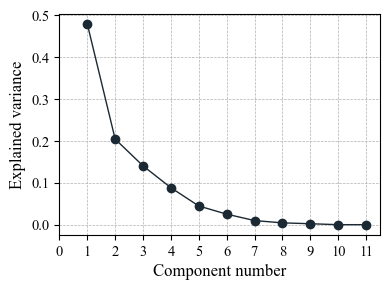

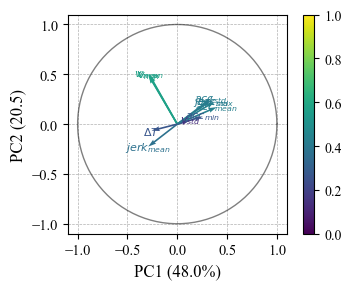

In [47]:
# 创建加速事件PCA降维类
acc_dr = DimensionReduce(ss_acc_index)
acc_tve = acc_dr.calc_total_variance_explain()
acc_tve.to_excel('./事件聚类/加速事件_all指标_主成分总解释方差.xlsx', index=False)

acc_pc_load = acc_dr.calc_PC_loadings()
acc_pc_load.to_excel('./事件聚类/加速事件_all指标_主成分载荷.xlsx', index=True)

acc_rc_load = acc_dr.calc_RC_loadings()
acc_rc_load.to_excel('./事件聚类/加速事件_all指标_主成分旋转载荷.xlsx', index=True)

show_scree_plot(acc_tve)
plt.savefig('./事件聚类/加速事件_all指标_主成分碎石图.pdf')

acc_labels = [r'$v_{max}$',r'$v_{mean}$', r'$v_{std}$', r'$v_{min}$',
          r'$acc_{max}$', r'$acc_{mean}$', r'$acc_{std}$',  r'$acc_{min}$',
          r'$jerk_{mean}$', r'$jerk_{std}$', r'$\Delta T$']
show_correlation_plot(acc_pc_load, x_cols=['PC1','PC2'], text_labels=acc_labels, xy_labels=['PC1 (48.0%)', 'PC2 (20.5)'])
plt.savefig('./事件聚类/加速事件_all指标_原始特征与主成分相关关系图.pdf')

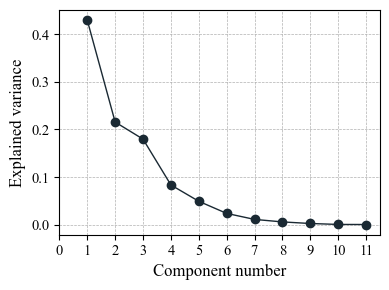

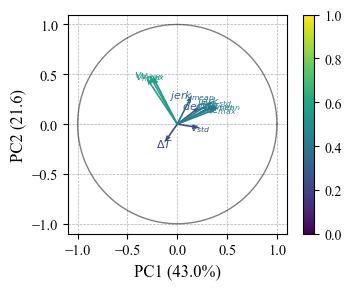

In [36]:
# 创建减速事件PCA降维类
dec_dr = DimensionReduce(ss_dec_index)
dec_tve = dec_dr.calc_total_variance_explain()
dec_tve.to_excel('./事件聚类/减速事件_all指标_主成分总解释方差.xlsx', index=False)

dec_pc_load = dec_dr.calc_PC_loadings()
dec_pc_load.to_excel('./事件聚类/减速事件_all指标_主成分载荷.xlsx', index=True)

dec_rc_load = dec_dr.calc_RC_loadings()
dec_rc_load.to_excel('./事件聚类/减速事件_all指标_主成分旋转载荷.xlsx', index=True)

show_scree_plot(dec_tve)
plt.savefig('./事件聚类/减速事件_all指标_主成分碎石图.pdf')

dec_labels = [r'$v_{max}$',r'$v_{mean}$', r'$v_{std}$', r'$v_{min}$',
          r'$dec_{max}$', r'$dec_{mean}$', r'$dec_{std}$',  r'$dec_{min}$',
          r'$jerk_{mean}$', r'$jerk_{std}$', r'$\Delta T$']
show_correlation_plot(dec_pc_load, x_cols=['PC1','PC2'], text_labels=dec_labels, xy_labels=['PC1 (43.0%)', 'PC2 (21.6)'])
plt.savefig('./事件聚类/减速事件_all指标_原始特征与主成分相关关系图.pdf')

### 5. 一层速度聚类
#### 对加速、减速事件速度特征['max_v','mean_v', 'std_v', 'min_v']进行标准化和降维，
#### 基于降维后的特征进行一层聚类分析，将速度划分为加速事件过程中的速度划分为低、中、高

In [37]:
data = pd.concat([acc_data,dec_data],axis=0).reset_index(drop=True)

#### 5.1 速度特征标准化

In [48]:
# 读取标准化后的一级聚类特征数据
speed_index = data[['max_v','mean_v', 'std_v', 'min_v']]
speed_ss = Standard(speed_index)
ss_speed_index = speed_ss.out_scaled_result()
# 速度聚类模型保存
joblib.dump(speed_ss,'./事件聚类/all事件_speed指标_数据标准化模型.pkl') 

['./事件聚类/all事件_speed指标_数据标准化模型.pkl']

#### 5.2 速度特征降维,追加至加速事件原始数据中

In [39]:
# 创建加速事件PCA降维类
speed_dr = DimensionReduce(ss_speed_index,n_pc=2)
speed_tve = speed_dr.calc_total_variance_explain()
speed_tve.to_excel('./事件聚类/all事件_speed指标_主成分总解释方差.xlsx', index=False)

speed_rc_load = speed_dr.calc_RC_loadings()
speed_rc_load.to_excel('./事件聚类/all事件_speed指标_主成分旋转载荷.xlsx', index=True)

data = pd.concat([data,speed_dr.pcs],axis=1)
data = data.rename(columns={'PC1': 'v_PC1', 'PC2': 'v_PC2'})
data.to_excel('./事件聚类/all事件_speed指标_主成分结果.xlsx', index=False)

# 速度PCA降维模型保存
joblib.dump(speed_dr,'./事件聚类/all事件_speed指标_PCA模型.pkl') 

['./事件聚类/all事件_speed指标_PCA模型.pkl']

#### 5.3 基于速度降维后的主成分['v_PC1', 'v_PC2']进行聚类，返回聚类结果

In [ ]:
data = pd.read_excel('./事件聚类/all事件_speed指标_主成分结果.xlsx')
# 创建加速、减速事件的聚类类
speed_clus = Clustering(data[['v_PC1', 'v_PC2']], calc_best_cluster_flag=False, max_cluster=10, best_cluster=2)
print('完成聚类')
if speed_clus.calc_best_cluster_flag:
    speed_clus.show_silhouette_clusters()
    print('轮廓系数：{}'.format(speed_clus.silhouette_scores))
    plt.savefig('./事件聚类/all事件_speed指标_聚类数与轮廓系数图.pdf')
data['v_label'] = speed_clus.best_labels
data.to_excel('./事件聚类/all事件_speed指标_聚类结果.xlsx', index= False)

# 速度聚类模型保存
joblib.dump(speed_clus,'./事件聚类/all事件_speed指标_聚类模型.pkl') 

The average silhouette score of all samples:  0.48270426062530386
The average silhouette score of cluster 0 : 0.46
The average silhouette score of cluster 1 : 0.51


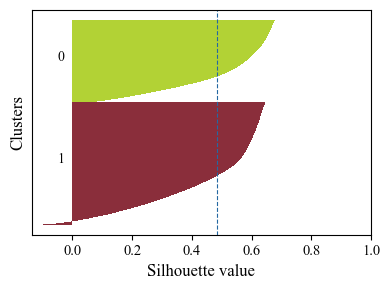

In [18]:
data = pd.read_excel('./事件聚类/all事件_speed指标_主成分结果.xlsx')
cls_list = list(data[['max_v','mean_v', 'std_v', 'min_v','v_label']].groupby('v_label').mean().sort_values(by='max_v').index)
show_silhouette_plot(data.sample(n=100000, random_state=42),x_cols=['v_PC1', 'v_PC2'], y_col='v_label', 
                     num_cls=2, cls_list=cls_list, colors=['#8a2e3b', '#b2d235', '#dea32c', '#6950a1'])
plt.savefig('./事件聚类/all事件_speed指标_最优聚类轮廓图.png',dpi=1200)

#### 5.4 基于聚类结果绘制聚类散点图

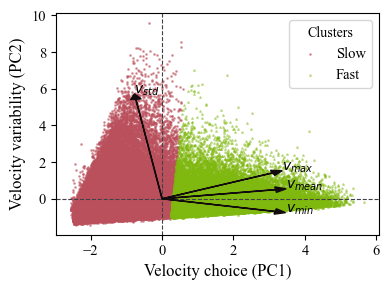

In [29]:
data = pd.read_excel('./事件聚类/all事件_speed指标_聚类结果.xlsx')
speed_dr = joblib.load('./事件聚类/all事件_speed指标_PCA模型.pkl')
cls_list = list(data[['max_v','mean_v', 'std_v', 'min_v','v_label']].groupby('v_label').mean().sort_values(by='max_v').index)

show_class_result(data.sample(100000, random_state=42), PC_list=['v_PC1','v_PC2'], label='v_label', 
                  pca=speed_dr.pca, num_cls=2, feature_num=4, 
                  arrow_text_list=[r'$v_{max}$',r'$v_{mean}$', r'$v_{std}$', r'$v_{min}$'], 
                  xy_labels=['Velocity choice (PC1)', 'Velocity variability (PC2)'], 
                  cls_list=cls_list, cls_legend=['Slow','Fast'], cls_colors = ['#bb505d','#7fb80e','#4e72b8'], 
                  vector_scale = 1.5)

plt.savefig('./事件聚类/all事件_speed指标_聚类散点图.png', dpi=1200)

#### 5.5 求解速度聚类中心点

In [16]:
centers = speed_clus.best_kmeans.cluster_centers_
x_centers = speed_dr.pca.inverse_transform(centers)
x_centers = speed_ss.scaler.inverse_transform(x_centers)
x_centers = pd.DataFrame(x_centers, columns=speed_index.columns)
x_centers.to_excel('./事件聚类/all事件_speed指标_聚类中心点.xlsx', index=False)

### 6. 加速事件中不同速度分类下进行二阶聚类，获取激进加速度事件

#### 6.1 对加速事件中的加速度特征进行标准化，并返回标准化后的结果scaler_acc_X

In [51]:
data = pd.read_excel('./事件聚类/all事件_speed指标_聚类结果.xlsx')
# 提取加速事件的加速度特征指标进行标准化
acc_data = data[data['logo']=='加速事件'].reset_index(drop=True)
acc_X = acc_data[['max_acc_lon', 'mean_acc_lon','std_acc_lon', 'min_acc_lon','mean_jerk', 'std_jerk', 'duration']]
acc_ss = Standard(acc_X)
scaler_acc_X = acc_ss.out_scaled_result()
# 速度聚类模型保存
joblib.dump(acc_ss,'./事件聚类/加速事件_acc指标_数据标准化模型.pkl') 

['./事件聚类/加速事件_acc指标_数据标准化模型.pkl']

In [52]:
# 提取减速事件的减速度特征指标进行标准化
dec_data = data[data['logo']=='减速事件'].reset_index(drop=True)
dec_X = dec_data[['max_dec_lon', 'mean_dec_lon','std_dec_lon', 'min_dec_lon','mean_jerk', 'std_jerk', 'duration']]
dec_ss = Standard(dec_X)
scaler_dec_X = dec_ss.out_scaled_result()
# 速度聚类模型保存
joblib.dump(dec_ss,'./事件聚类/减速事件_dec指标_数据标准化模型.pkl') 

['./事件聚类/减速事件_dec指标_数据标准化模型.pkl']

#### 6.2 对加速、减速特征进行进行降维，追加到原始速度中

In [53]:
# 创建加速事件PCA降维类
acc_dr = DimensionReduce(scaler_acc_X,n_pc=2)
acc_tve = acc_dr.calc_total_variance_explain()
acc_tve.to_excel('./事件聚类/加速事件_acc指标_主成分总解释方差.xlsx', index=False)

acc_rc_load = acc_dr.calc_RC_loadings()
acc_rc_load.to_excel('./事件聚类/加速事件_acc指标_主成分旋转载荷.xlsx', index=True)

acc_data = pd.concat([acc_data,acc_dr.pcs],axis=1)
acc_data = acc_data.rename(columns={'PC1': 'acc_PC1', 'PC2': 'acc_PC2'})
acc_data.to_excel('./事件聚类/加速事件_acc指标_主成分结果.xlsx', index=False)
# 速度聚类模型保存
joblib.dump(acc_dr,'./事件聚类/加速事件_acc指标_降维模型.pkl')

['./事件聚类/加速事件_acc指标_降维模型.pkl']

In [54]:
# 创建减速事件PCA降维类
dec_dr = DimensionReduce(scaler_dec_X,n_pc=2)
dec_tve = dec_dr.calc_total_variance_explain()
dec_tve.to_excel('./事件聚类/减速事件_dec指标_主成分总解释方差.xlsx', index=False)

dec_rc_load = dec_dr.calc_RC_loadings()
dec_rc_load.to_excel('./事件聚类/减速事件_dec指标_主成分旋转载荷.xlsx', index=True)

dec_data = pd.concat([dec_data,dec_dr.pcs],axis=1)
dec_data = dec_data.rename(columns={'PC1': 'dec_PC1', 'PC2': 'dec_PC2'})
dec_data.to_excel('./事件聚类/减速事件_dec指标_主成分结果.xlsx', index=False)
# 速度聚类模型保存
joblib.dump(dec_dr,'./事件聚类/减速事件_dec指标_降维模型.pkl')

['./事件聚类/减速事件_dec指标_降维模型.pkl']

#### 6.3 基于加速度降维后的主成分['acc_PC1', 'acc_PC2']进行二级聚类，返回聚类结果和聚类中心点

完成0聚类
The average silhouette score of all samples:  0.4540660586862621
The average silhouette score of cluster 0 : 0.55
The average silhouette score of cluster 1 : 0.34
The average silhouette score of cluster 2 : 0.21
完成1聚类
The average silhouette score of all samples:  0.3894929653960368
The average silhouette score of cluster 0 : 0.52
The average silhouette score of cluster 1 : 0.29
The average silhouette score of cluster 2 : 0.12


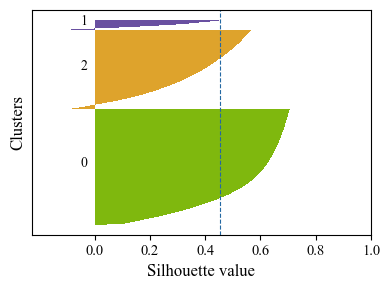

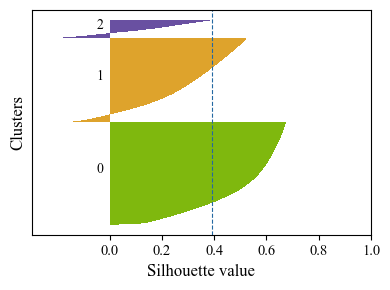

In [55]:
acc_data = pd.read_excel('./事件聚类/加速事件_acc指标_主成分结果.xlsx')
all_acc_event = []
for i in range(2):
    acc_event = acc_data[acc_data['v_label']==i]
    acc_clus = Clustering(acc_event[['acc_PC1', 'acc_PC2']], calc_best_cluster_flag=False, best_cluster=3)
    print('完成{}聚类'.format(i))
    if acc_clus.calc_best_cluster_flag:
        acc_clus.show_silhouette_clusters()
        print('速度{}轮廓系数：{}'.format(i, acc_clus.silhouette_scores))
        plt.savefig('./事件聚类/加速事件_acc指标_speed{}_聚类数与轮廓系数图.pdf'.format(i))
    acc_event['acc_label'] = acc_clus.best_labels
    all_acc_event.append(acc_event)
    # 绘制加速、减速事件轮廓系数图
    cls_list = list(acc_event[['max_acc_lon','acc_label']].groupby('acc_label').mean().sort_values(by='max_acc_lon').index)
    show_silhouette_plot(acc_event,x_cols=['acc_PC1', 'acc_PC2'], y_col='acc_label', num_cls=3, cls_list=cls_list, colors=['#7fb80e', '#dea32c', '#6950a1'])
    plt.savefig('./事件聚类/加速事件_acc指标_speed{}_最优聚类轮廓图.png'.format(i), dpi=1200)
    # 求解聚类中心
    centers = acc_clus.best_kmeans.cluster_centers_
    x_centers = acc_dr.pca.inverse_transform(centers)
    x_centers = acc_ss.scaler.inverse_transform(x_centers)
    x_centers = pd.DataFrame(x_centers, columns=acc_X.columns)
    x_centers.to_excel('./事件聚类/加速事件_acc指标_speed{}_聚类中心点.xlsx'.format(i),index=False)

all_acc_event = pd.concat(all_acc_event, axis=0).reset_index(drop=True)
all_acc_event.to_excel('./事件聚类/加速事件_acc指标_聚类结果.xlsx', index=False)

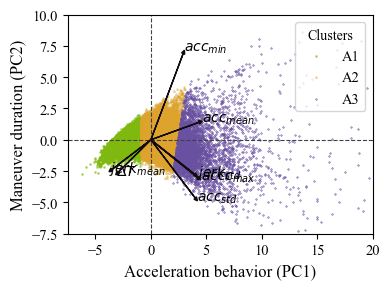

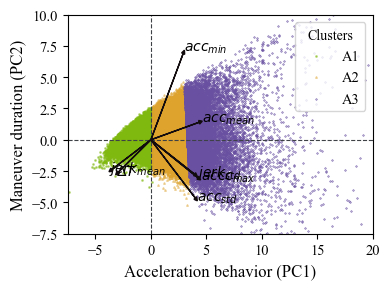

In [18]:
acc_data = pd.read_excel('./事件聚类/加速事件_acc指标_聚类结果.xlsx')
# 速度聚类模型保存
acc_dr = joblib.load('./事件聚类/加速事件_acc指标_降维模型.pkl')
for i in range(2):
    event = acc_data[acc_data['v_label']==i]
    cls_list = list(event[['max_acc_lon','acc_label']].groupby('acc_label').mean().sort_values(
    by='max_acc_lon').index)
    show_class_result(event, PC_list=['acc_PC1','acc_PC2'], label='acc_label',  pca=acc_dr.pca, 
                  num_cls=3, feature_num=7, 
                  arrow_text_list=[r'$accc_{max}$', r'$acc_{mean}$', r'$acc_{std}$',  r'$acc_{min}$', r'$jerk_{mean}$', r'$jerk_{std}$', r'$\Delta T$'],
                  xy_labels = ['Acceleration behavior (PC1)', 'Maneuver duration (PC2)'], 
                  cls_list=cls_list, cls_legend=['A1','A2', 'A3'], 
                  cls_colors = ['#7fb80e', '#dea32c', '#6950a1'], 
                  vector_scale = 1.5)
    plt.savefig('./事件聚类/加速事件_acc指标_速度{}_聚类散点图.png'.format(i), dpi=1200)

In [14]:
acc_data[acc_data['v_label']==0].groupby('acc_label').count()

NameError: name 'acc_data' is not defined

In [8]:
acc_data[acc_data['v_label']==0].groupby('acc_label').mean()

,phone,duration,min_v,max_v,mean_v,std_v,max_acc_lon,mean_acc_lon,std_acc_lon,min_acc_lon,...,min_jerk,max_dec_lon,mean_dec_lon,std_dec_lon,min_dec_lon,v_PC1,v_PC2,v_label,acc_PC1,acc_PC2
acc_label,,,,,,,,,,,,,,,,,,,,,
0,1.438523e+10,13.511612,58.866123,68.136792,63.492625,3.119665,0.397919,0.209937,0.106365,0.057247,...,-0.319605,NaN,NaN,NaN,NaN,1.847696,-0.161958,0.0,-1.978716,-0.023362
1,1.443606e+10,4.240027,56.969902,65.267110,61.067298,3.797856,1.381181,0.688665,0.546105,0.230404,...,-1.259222,NaN,NaN,NaN,NaN,1.582043,0.066553,0.0,4.491315,-0.715192
2,1.442693e+10,6.997648,56.139967,64.534025,60.330896,3.135368,0.722886,0.381562,0.222224,0.123342,...,-0.622969,NaN,NaN,NaN,NaN,1.544649,-0.205420,0.0,0.211829,0.015784


完成0聚类
The average silhouette score of all samples:  0.3999611287527497
The average silhouette score of cluster 0 : 0.51
The average silhouette score of cluster 1 : 0.31
The average silhouette score of cluster 2 : 0.16
完成1聚类
The average silhouette score of all samples:  0.35696671942234576
The average silhouette score of cluster 0 : 0.43
The average silhouette score of cluster 1 : 0.30
The average silhouette score of cluster 2 : 0.13


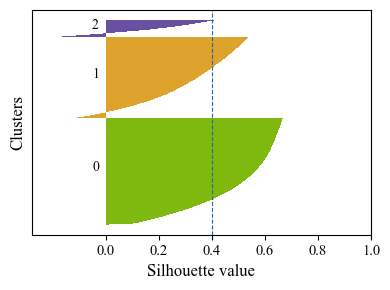

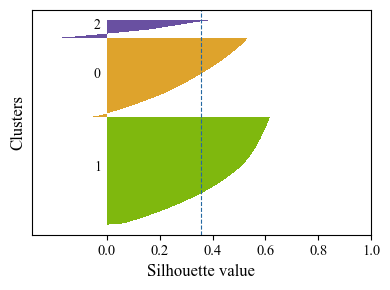

In [25]:
dec_data = pd.read_excel('./事件聚类/减速事件_dec指标_主成分结果.xlsx')
all_dec_event = []
for i in range(2):
    dec_event = dec_data[dec_data['v_label']==i]
    dec_clus = Clustering(dec_event[['dec_PC1', 'dec_PC2']], calc_best_cluster_flag=False, best_cluster=3)
    print('完成{}聚类'.format(i))
    if dec_clus.calc_best_cluster_flag:
        dec_clus.show_silhouette_clusters()
        print('速度{}轮廓系数：{}'.format(i, dec_clus.silhouette_scores))
        plt.savefig('./事件聚类/减速事件_dec指标_speed{}_聚类数与轮廓系数图.pdf'.format(i))
    dec_event['dec_label'] = dec_clus.best_labels
    all_dec_event.append(dec_event)
    # 绘制加速、减速事件轮廓系数图
    cls_list = list(dec_event[['max_dec_lon','dec_label']].groupby('dec_label').mean().sort_values(by='max_dec_lon').index)
    show_silhouette_plot(dec_event,x_cols=['dec_PC1', 'dec_PC2'], y_col='dec_label', num_cls=3, cls_list=cls_list, colors=['#7fb80e', '#dea32c', '#6950a1'])
    plt.savefig('./事件聚类/减速事件_dec指标_speed{}_最优聚类轮廓图.png'.format(i), dpi=1200)
    # 求解聚类中心
    centers = dec_clus.best_kmeans.cluster_centers_
    x_centers = dec_dr.pca.inverse_transform(centers)
    x_centers = dec_ss.scaler.inverse_transform(x_centers)
    x_centers = pd.DataFrame(x_centers, columns=dec_X.columns)
    x_centers.to_excel('./事件聚类/减速事件_dec指标_speed{}_聚类中心点.xlsx'.format(i),index=False)
all_dec_event = pd.concat(all_dec_event, axis=0).reset_index(drop=True)
all_dec_event.to_excel('./事件聚类/减速事件_dec指标_聚类结果.xlsx', index=False)

In [17]:
dec_data[dec_data['v_label']==0].groupby('dec_label').count()

,phone,start_time,end_time,duration,min_v,max_v,mean_v,std_v,max_acc_lon,mean_acc_lon,...,logo,max_dec_lon,mean_dec_lon,std_dec_lon,min_dec_lon,v_PC1,v_PC2,v_label,dec_PC1,dec_PC2
dec_label,,,,,,,,,,,,,,,,,,,,,
0,43156,43156,43156,43156,43156,43156,43156,43156,0,0,...,43156,43156,43156,43156,43156,43156,43156,43156,43156,43156
1,32658,32658,32658,32658,32658,32658,32658,32658,0,0,...,32658,32658,32658,32658,32658,32658,32658,32658,32658,32658
2,6853,6853,6853,6853,6853,6853,6853,6853,0,0,...,6853,6853,6853,6853,6853,6853,6853,6853,6853,6853


In [12]:
dec_data[dec_data['v_label']==0].groupby('dec_label').mean()

,phone,duration,min_v,max_v,mean_v,std_v,max_acc_lon,mean_acc_lon,std_acc_lon,min_acc_lon,...,min_jerk,max_dec_lon,mean_dec_lon,std_dec_lon,min_dec_lon,v_PC1,v_PC2,v_label,dec_PC1,dec_PC2
dec_label,,,,,,,,,,,,,,,,,,,,,
0,1.439845e+10,12.082399,60.906778,69.865020,65.505034,3.070049,NaN,NaN,NaN,NaN,...,-0.285404,0.486296,0.232323,0.137292,0.057983,2.034291,-0.160273,0.0,-1.918356,0.085155
1,1.441737e+10,6.852318,57.254051,66.883140,62.450535,3.639160,NaN,NaN,NaN,NaN,...,-0.520326,0.934311,0.446729,0.301739,0.127518,1.695846,0.031977,0.0,0.067009,0.415075
2,1.439801e+10,5.033416,55.302962,67.248242,62.110736,5.045986,NaN,NaN,NaN,NaN,...,-0.861492,1.720682,0.841346,0.632829,0.271892,1.559944,0.607783,0.0,3.574301,0.444591


In [11]:
len(dec_data[dec_data['v_label']==0])

82667

#### 6.4 基于加速度聚类结果绘制聚类散点图

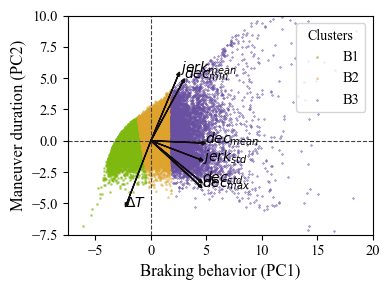

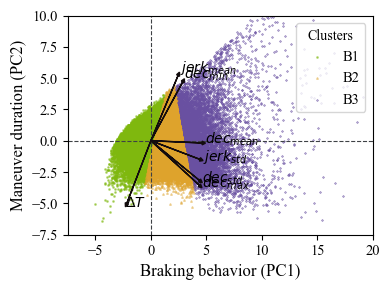

In [20]:
dec_data = pd.read_excel('./事件聚类/减速事件_dec指标_聚类结果.xlsx')
# 速度聚类模型保存
dec_dr = joblib.load('./事件聚类/减速事件_dec指标_降维模型.pkl')
for i in range(2):
    event = dec_data[dec_data['v_label']==i]
    cls_list = list(event[['max_dec_lon','dec_label']].groupby('dec_label').mean().sort_values(by='max_dec_lon').index)
    show_class_result(event, PC_list=['dec_PC1','dec_PC2'], label='dec_label',  pca=dec_dr.pca, 
                  num_cls=3, feature_num=7, 
                  arrow_text_list=[r'$dec_{max}$', r'$dec_{mean}$', r'$dec_{std}$',  r'$dec_{min}$', r'$jerk_{mean}$', r'$jerk_{std}$', r'$\Delta T$'],
                  xy_labels = ['Braking behavior (PC1)', 'Maneuver duration (PC2)'], 
                  cls_list=cls_list, cls_legend=['B1','B2', 'B3'], 
                  cls_colors = ['#7fb80e', '#dea32c', '#6950a1'], 
                  vector_scale = 1.5)
    plt.savefig('./事件聚类/减速事件_dec指标_速度{}_聚类散点图.png'.format(i), dpi=1200)

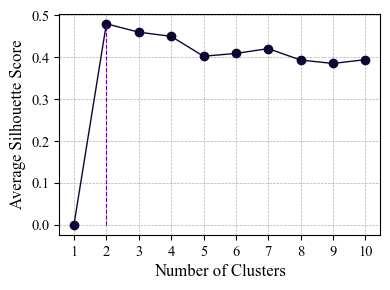

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.rc('font',family='Times New Roman')

data = pd.read_excel('./事件聚类/all事件_speed指标_聚类数与轮廓系数对应表.xlsx')
fig,ax = plt.subplots(figsize=(4,3))
plt.plot(data['cluster'], data['silhouette'],'-o', color='#120432',linewidth=1)
plt.plot([2,2],[0,data['silhouette'].iloc[1]],'--',color='#5E0583', linewidth=0.8)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Average Silhouette Score', fontsize=12)
plt.xticks(data['cluster'],fontsize=10.5)
plt.yticks(fontsize=10.5)
plt.grid(linestyle='--',linewidth=0.5)
plt.tight_layout()
plt.savefig('./事件聚类/all事件_speed指标_聚类数与轮廓系数对应关系.pdf')